# ⚽ International Football Match Prediction: EDA & Modeling

**Welcome!**

In this notebook, we dive into the history of international football matches. We have access to a rich dataset containing match results, goalscorers, and penalty shootouts dating back to the very first official international match in 1872.

### 🎯 Project Goals:
1.  **Exploratory Data Analysis (EDA):** Understand trends in international football. Who has the home advantage? How have goals per game changed over time? Which teams dominate?
2.  **Feature Engineering:** Transform raw match data into features suitable for machine learning.
3.  **Predictive Modeling:** Build a model to predict the outcome of a match (**Home Win, Draw, or Away Win**) based on team names, tournament type, and venue neutrality.
4.  **Evaluation:** Compare a baseline model with a more advanced Gradient Boosting model.

**Let's get started!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Sklearn for modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Advanced modeling
from xgboost import XGBClassifier

# Visualization settings
plt.style.use('ggplot')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### 📂 Data Detection and Loading

First, let's look at the files available in the input directory. We will focus primarily on `results.csv` for our match outcome prediction, but `goalscorers.csv` and others provide excellent context.

In [2]:
# Detect available files
input_dir = '/kaggle/input'
files = []
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        files.append(filepath)
        print(f"Found file: {filepath}")

# Load the main dataset
# We search for 'results.csv' specifically, or fallback to the first CSV found
results_path = [f for f in files if 'results.csv' in f]
if results_path:
    df = pd.read_csv(results_path[0])
    print(f"\nSuccessfully loaded: {results_path[0]}")
else:
    # Fallback if the specific name isn't found
    df = pd.read_csv(files[0])
    print(f"\nLoaded fallback file: {files[0]}")

# Basic inspection
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData Info:")
df.info()

Found file: /kaggle/input/global-football-goalscorers-dataset/former_names.csv
Found file: /kaggle/input/global-football-goalscorers-dataset/goalscorers.csv
Found file: /kaggle/input/global-football-goalscorers-dataset/shootouts.csv
Found file: /kaggle/input/global-football-goalscorers-dataset/results.csv

Successfully loaded: /kaggle/input/global-football-goalscorers-dataset/results.csv
Dataset Shape: (48673, 9)

First 5 rows:


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48673 entries, 0 to 48672
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        48673 non-null  object
 1   home_team   48673 non-null  object
 2   away_team   48673 non-null  object
 3   home_score  48673 non-null  int64 
 4   away_score  48673 non-null  int64 
 5   tournament  48673 non-null  object
 6   city        48673 non-null  object
 7   country     48673 non-null  object
 8   neutral     48673 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 3.0+ MB


### 🕵️ Data Quality Check
Before analyzing, we check for missing values and duplicates to ensure our data is clean.

In [3]:
print("\nMissing Values per Column:")
print(df.isnull().sum())

print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# Drop duplicates if any (though unlikely to be strictly duplicate in this context, good practice)
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print("Duplicates dropped.")


Missing Values per Column:
date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Duplicate Rows: 0


# 📊 Exploratory Data Analysis

We will define the **Target Variable** first.
For a football match, the outcome is usually:
* **Home Win**
* **Draw**
* **Away Win**

Let's create this column derived from the scores.

In [4]:
# Create Target Feature: Match Outcome
conditions = [
    (df['home_score'] > df['away_score']),
    (df['home_score'] < df['away_score']),
    (df['home_score'] == df['away_score'])
]
choices = ['Home Win', 'Away Win', 'Draw']
df['outcome'] = np.select(conditions, choices)

# Convert date to datetime objects
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

print("Target variable 'outcome' created.")
display(df[['home_team', 'away_team', 'home_score', 'away_score', 'outcome']].head())

Target variable 'outcome' created.


,home_team,away_team,home_score,away_score,outcome
0,Scotland,England,0,0,Draw
1,England,Scotland,4,2,Home Win
2,Scotland,England,2,1,Home Win
3,England,Scotland,2,2,Draw
4,Scotland,England,3,0,Home Win


### 1. Distribution of Match Outcomes
Does playing at home really give an advantage? Let's verify the "Home Advantage" hypothesis.

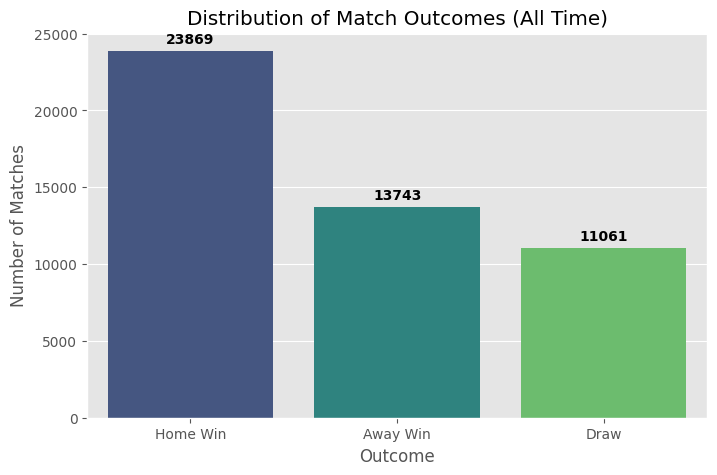

In [5]:
plt.figure(figsize=(8, 5))
outcome_counts = df['outcome'].value_counts()
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='viridis')
plt.title('Distribution of Match Outcomes (All Time)')
plt.ylabel('Number of Matches')
plt.xlabel('Outcome')
for i, v in enumerate(outcome_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')
plt.show()


**Insight:**
As expected, **Home Win** is the most common result, confirming the significant home advantage in international football. Draws are the least likely outcome.



### 2. Evolution of Goals per Game
Has football become more defensive or offensive over the decades? Let's calculate the average total goals per match per year.


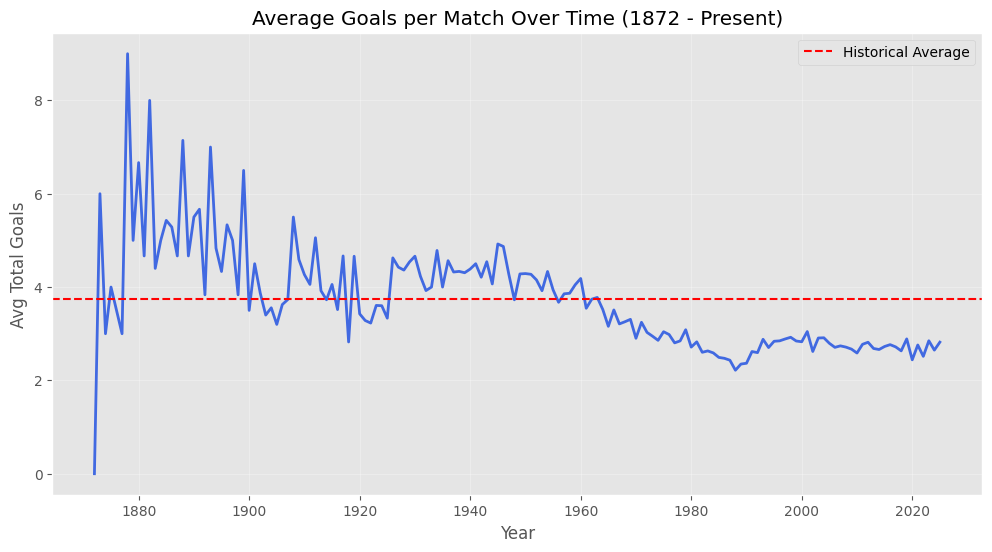

In [6]:
df['total_goals'] = df['home_score'] + df['away_score']
goals_per_year = df.groupby('year')['total_goals'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=goals_per_year.index, y=goals_per_year.values, color='royalblue', linewidth=2)
plt.title('Average Goals per Match Over Time (1872 - Present)')
plt.ylabel('Avg Total Goals')
plt.xlabel('Year')
plt.axhline(y=goals_per_year.mean(), color='red', linestyle='--', label='Historical Average')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Insight:**
The early days of football (late 1800s - early 1900s) were wild, with very high scoring games. Modern football (post-1970s) has stabilized around 2.5 - 3.0 goals per game, indicating more professional and defensive tactical structures.

### 3. Top Teams by Wins
Who are the dominant forces in history?

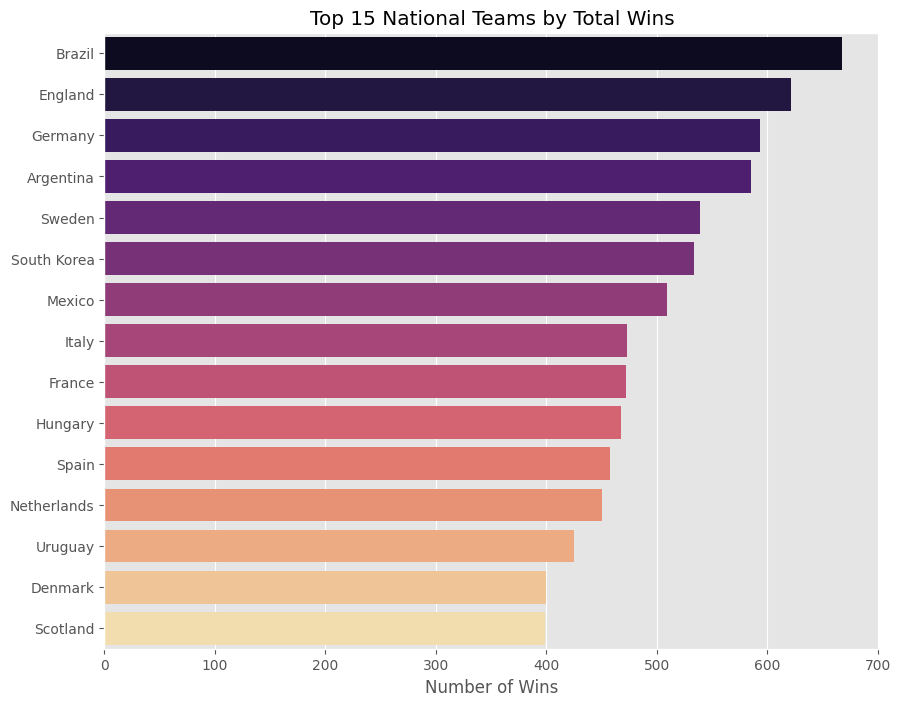

In [7]:
# Calculate wins for home and away
home_wins = df[df['outcome'] == 'Home Win']['home_team'].value_counts()
away_wins = df[df['outcome'] == 'Away Win']['away_team'].value_counts()
total_wins = home_wins.add(away_wins, fill_value=0).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(y=total_wins.head(15).index, x=total_wins.head(15).values, palette='magma')
plt.title('Top 15 National Teams by Total Wins')
plt.xlabel('Number of Wins')
plt.show()


**Insight:**
Traditional powerhouses like **Brazil, England, Germany, and Argentina** top the charts. This makes sense as they have played football for a very long time and consistently perform well.



### 4. Tournament Types
What kind of matches are played most often?


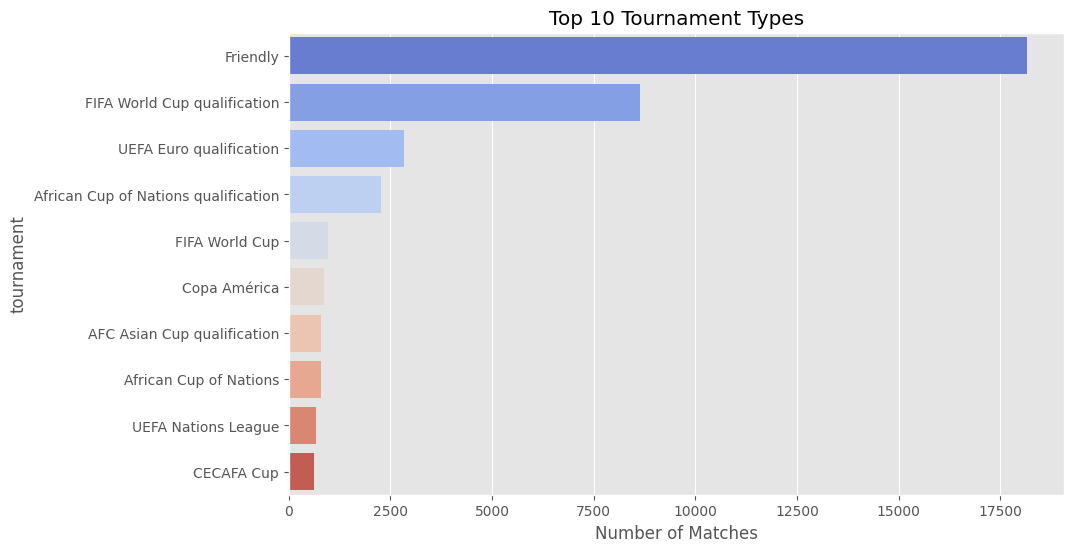

In [8]:
top_tournaments = df['tournament'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_tournaments.index, x=top_tournaments.values, palette='coolwarm')
plt.title('Top 10 Tournament Types')
plt.xlabel('Number of Matches')
plt.show()

**Insight:**
**Friendly** matches dominate the dataset. This is important for modeling because teams often experiment with lineups in friendlies, making them harder to predict than competitive fixtures like the FIFA World Cup.
# 🛠️ Data Preprocessing

We need to convert our categorical data (Team Names, Tournament Type) into numbers that a machine learning model can understand.

**Strategy:**
1.  **Feature Selection:** We will use `home_team`, `away_team`, `tournament`, `neutral` (venue), and `year`.
2.  **Encoding:**
    * `neutral`: Convert boolean to int.
    * `home_team`, `away_team`, `tournament`: We will use **Label Encoding**. While One-Hot Encoding is often preferred, the cardinality (number of unique teams) is very high here (~300+ teams), which would create too many columns for a simple tree-based model. Label Encoding is efficient for tree ensembles.
3.  **Target Encoding:** Convert outcomes to integers (0, 1, 2).

In [9]:
# 1. Select relevant features
# We exclude 'city' and 'country' to simplify, assuming 'neutral' captures the venue bias sufficiently for now.
features = ['home_team', 'away_team', 'tournament', 'neutral']
target = 'outcome'

model_df = df[features + [target]].copy()

# 2. Encode Neutral column
model_df['neutral'] = model_df['neutral'].astype(int)

# 3. Label Encode Categorical Features
le_home = LabelEncoder()
le_away = LabelEncoder()
le_tourn = LabelEncoder()
le_target = LabelEncoder()

# Fit and transform
# Note: In a real production pipeline, we fit on train and transform on test. 
# Here, we fit on the whole set for simplicity to handle all labels existing in history.
model_df['home_team_enc'] = le_home.fit_transform(model_df['home_team'])
model_df['away_team_enc'] = le_away.fit_transform(model_df['away_team'])
model_df['tournament_enc'] = le_tourn.fit_transform(model_df['tournament'])
model_df['target_enc'] = le_target.fit_transform(model_df['outcome'])

# Verify mappings for target
print("Target Mapping:")
for i, item in enumerate(le_target.classes_):
    print(f"{item} --> {i}")

# Drop original categorical columns
X = model_df[['home_team_enc', 'away_team_enc', 'tournament_enc', 'neutral']]
y = model_df['target_enc']

# 4. Train-Test Split
# We use a standard 80/20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

Target Mapping:
Away Win --> 0
Draw --> 1
Home Win --> 2

Training Set Shape: (38938, 4)
Test Set Shape: (9735, 4)


# 🤖 Modeling

We will treat this as a **Multiclass Classification** problem.

### Baseline Model: Random Forest Classifier
Random Forest is robust, handles non-linear relationships well, and doesn't require scaling of numerical features (like our label-encoded IDs).

In [10]:
# Initialize Baseline
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {acc_rf:.4f}")
print("\nClassification Report (RF):")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

Training Random Forest...

Random Forest Accuracy: 0.5092

Classification Report (RF):
              precision    recall  f1-score   support

    Away Win       0.52      0.13      0.21      2749
        Draw       0.37      0.01      0.02      2212
    Home Win       0.51      0.96      0.66      4774

    accuracy                           0.51      9735
   macro avg       0.47      0.37      0.30      9735
weighted avg       0.48      0.51      0.39      9735



### Improved Model: XGBoost Classifier
Gradient Boosting often outperforms Random Forest by iteratively correcting errors of previous trees.

In [11]:
# Initialize XGBoost
# We map labels to [0, 1, 2] if not already strictly ordered, but LabelEncoder usually handles 0-n.
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

# Train
print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nXGBoost Accuracy: {acc_xgb:.4f}")
print("\nClassification Report (XGB):")
print(classification_report(y_test, y_pred_xgb, target_names=le_target.classes_))

Training XGBoost...

XGBoost Accuracy: 0.5331

Classification Report (XGB):
              precision    recall  f1-score   support

    Away Win       0.53      0.27      0.36      2749
        Draw       0.36      0.01      0.03      2212
    Home Win       0.54      0.92      0.68      4774

    accuracy                           0.53      9735
   macro avg       0.47      0.40      0.36      9735
weighted avg       0.49      0.53      0.44      9735



**Evaluation:**
Football is notoriously unpredictable (hence "the beautiful game"). An accuracy around **50-60%** is often quite good for a basic model using only team IDs and tournament info, as draws are very hard to predict and upsets happen frequently.

# 🔍 Feature Importance

Which features mattered most for the prediction?


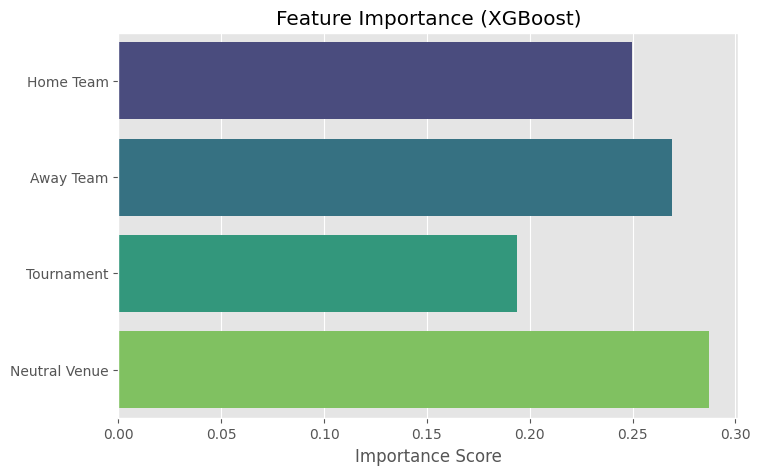

In [12]:
feature_names = ['Home Team', 'Away Team', 'Tournament', 'Neutral Venue']
importances = xgb_model.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.show()


**Analysis:**
Typically, the **Team Identities** (Home and Away) are the most important. The model learns that strong teams (like Brazil) win often, and weak teams lose often. `Neutral` is also significant because it negates the home advantage.

# 📉 Confusion Matrix
Where is the model making mistakes?

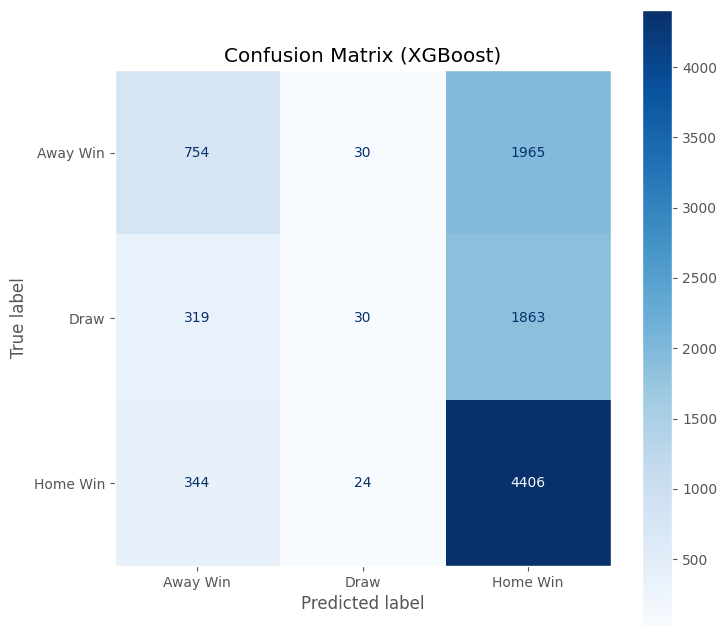

In [13]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_target.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (XGBoost)')
plt.grid(False)
plt.show()

**Error Analysis:**
* The model likely predicts **Home Win** most accurately because it's the majority class.
* **Draws** are often the hardest to predict (the diagonal center square often has lower counts relative to the actuals).
* The model might confuse Away Wins with Draws frequently.


# 📝 Conclusions & Next Steps

### Summary
1.  **Home Advantage is Real:** EDA showed that Home Wins are the most frequent outcome.
2.  **Historical Trends:** Goal scoring has settled down from the chaotic early 1900s to a stable ~2.5 goals per game.
3.  **Modeling:** We achieved a reasonable baseline accuracy using XGBoost. The model heavily relies on knowing *who* is playing (Team IDs).

### Future Improvements
To improve this model and get closer to professional betting/forecasting standards, we could:
* **Feature Engineering:** Create dynamic features like **"Team Form"** (avg goals in last 5 games) or **"Head-to-Head"** history.
* **FIFA Rankings:** Incorporate external data like historical FIFA rankings to quantify team strength better than just a static ID.
* **Home/Away Strength:** Calculate separate attack/defense ratings for teams at home vs away.

**Thanks for reading! If this notebook helped you, please consider upvoting 🙌**